# Imports

In [1]:
from skimage.transform import resize
import os
from multiprocessing import pool
import pickle
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import cv2
import torch
import random
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator

In [2]:
os.chdir("/Users/lisa/Documents/Master/sam-lab")
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = "sam_vit_h_4b8939.pth"
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

# Helper functions

In [3]:
def resize_image(image, old_spacing, new_spacing, order=3):# -> Any:
    new_shape = (int(np.round(old_spacing[0]/new_spacing[0]*float(image.shape[0]))),
                 int(np.round(old_spacing[1]/new_spacing[1]*float(image.shape[1]))),
                 int(np.round(old_spacing[2]/new_spacing[2]*float(image.shape[2]))))
    return resize(image, new_shape, order=order, mode='edge')

def convert_to_one_hot(seg):
    vals = np.unique(seg)
    res = np.zeros([len(vals)] + list(seg.shape), seg.dtype)
    for c in range(len(vals)):
        res[c][seg == c] = 1
    return res


def preprocess_image(nib_image, spacing_target, is_seg=False, keep_z_spacing=False):
    spacing = np.array(nib_image.header.get_zooms())[[2, 1, 0]]
    image = nib_image.get_fdata()
    if keep_z_spacing:
        spacing_target = list(spacing_target)
        spacing_target[0] = spacing[0]
    if not is_seg:
        order_img = 3
        if not keep_z_spacing:
            order_img = 1
        image = resize_image(image, spacing, spacing_target, order=order_img).astype(np.float32)
        image -= image.mean()
        image /= image.std()
    else:
        tmp = convert_to_one_hot(image)
        vals = np.unique(image)
        results = []
        for i in range(len(tmp)):
            results.append(resize_image(tmp[i].astype(float), spacing, spacing_target, 1)[None])
        image = vals[np.vstack(results).argmax(0)]
    return image

str_to_ind = {'DCM':0, 'HCM':1, 'MINF':2, 'NOR':3, 'RV':4}
ind_to_str = {}
for k in str_to_ind.keys():
    ind_to_str[str_to_ind[k]] = k

def process_patient(idx, patient_info, folder, folder_out, keep_z_spc):
    #print id
    # if id in [286, 288]:
    #     return
    patient_folder = os.path.join(folder, "patient%03.0d"%idx)
    if not os.path.isdir(patient_folder):
        return
    images = {}

    fname = os.path.join(patient_folder, "patient%03.0d_frame%02.0d.nii.gz" % (idx, patient_info[idx]['ED']))
    if os.path.isfile(fname):
        images["ed"] = nib.load(fname)
    fname = os.path.join(patient_folder, "patient%03.0d_frame%02.0d_gt.nii.gz" % (idx, patient_info[idx]['ED']))
    if os.path.isfile(fname):
        images["ed_seg"] = nib.load(fname)
    fname = os.path.join(patient_folder, "patient%03.0d_frame%02.0d.nii.gz" % (idx, patient_info[idx]['ES']))
    if os.path.isfile(fname):
        images["es"] = nib.load(fname)
    fname = os.path.join(patient_folder, "patient%03.0d_frame%02.0d_gt.nii.gz" % (idx, patient_info[idx]['ES']))
    if os.path.isfile(fname):
        images["es_seg"] = nib.load(fname)


    for k in images.keys():
        #print k
        images[k] = preprocess_image(images[k],spacing_target=(10, 1.25, 1.25), is_seg=(k == "ed_seg" or k == "es_seg"),keep_z_spacing=keep_z_spc)

    img_as_list = []
    for k in ['ed', 'ed_seg', 'es', 'es_seg']:
        if k not in images.keys():
            print(f"{idx} has missing key {k}")
        img_as_list.append(images[k][None])
    # Save all images of a patient in a stack of numpy in a folder
    try:
        all_img = np.vstack(img_as_list)
    except:
        print(f"{idx} has a problem with spacings")
    np.save(os.path.join(folder_out, "pat_%03.0d" %idx), all_img.astype(np.float32))
    
def generate_patient_info(folder,idx_start,idx_stop):
    patient_info={}
    for idx in range(idx_start,idx_stop+1):
        fldr = os.path.join(folder, 'patient%03.0d'%idx)
        print(fldr)
        if not os.path.isdir(fldr):
            print (f"could not find dir of patient {idx}")
            continue
        nfo = np.loadtxt(os.path.join(fldr, "Info.cfg"), dtype=str)
        print(patient_info)
        patient_info[idx] = {}
        patient_info[idx]['ed'] = int(nfo[0, 1])
        patient_info[idx]['es'] = int(nfo[1, 1])
        patient_info[idx]['height'] = float(nfo[3, 1])
        patient_info[idx]['pathology'] = nfo[2, 1]
        patient_info[idx]['weight'] = float(nfo[5, 1])
    return patient_info

# Did not test this yet
# To run the data preprocessing simultaneouly for big dataset
def run_preprocessing(folder_in,folder_out, idx_start,idx_stop, keep_z_spacing=True):
    patient_info = generate_patient_info(folder_in)

    if not os.path.isdir(folder_out):
        os.mkdir(folder_out)
    with open(os.path.join(folder_out, "patient_info.pkl"), 'w') as f:
        pickle.dump(patient_info, f)

    # beware of z spacing!!! see process_patient for more info!
    ids = range(idx_start,idx_stop+1)
    p = pool.Pool(8)
    p.map(process_patient, zip(ids, [patient_info]*len(ids), [folder]*len(ids), [folder_out]*len(ids), [keep_z_spacing]*len(ids)))
    p.close()
    p.join()


In [71]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=10):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='o', s=marker_size)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='o', s=marker_size)   
    


# Load image

In [5]:
os.chdir("/Users/lisa/Documents/Master/sam-lab/ACDC/database/training/patient001")
patient_001 = nib.load("patient001_frame01.nii.gz")
sl = 7 #slice number 
after = preprocess_image(patient_001,spacing_target=(10, 1.25, 1.25),keep_z_spacing=True)
image = after[:,:,sl]
patient_001_gt = nib.load("patient001_frame01_gt.nii.gz")
after_gt = preprocess_image(patient_001_gt,is_seg = True, spacing_target=(10, 1.25, 1.25),keep_z_spacing=True)
ground_truth = after_gt[:,:,sl]

In [6]:
# Convert to RGB
image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
# Change pixel values from [-1,1] to [0,255] range, np.uint8 type because SAM only accepts these values for RGB image
image = cv2.normalize(image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
image = image.astype(np.uint8)

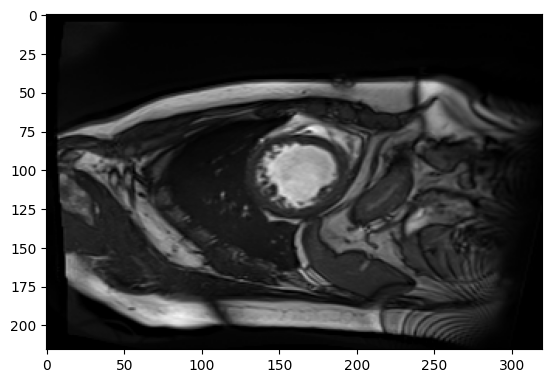

In [7]:
plt.imshow(image, cmap='gray')
plt.show()

# Set Image to Predictor

In [8]:
predictor = SamPredictor(sam)
predictor.set_image(image)

# Make prompt

In [34]:
# Choose one class from the ground truth and sample x random points from it to be the input
def sample_from_class(ground_truth, target_class: int, n_points: int):
    '''
    Generates a list of randomly sampled points from one class of the ground_truth and returns
    them in a readable form for SAM.

    Arguments:
    ground_truth: 2D-array, assigned labels of the original image
    target_class: integer, class to which the sampled points should belong
    n_points: number of points that should be returned

    Returns:
    list of n points belonging to the target_class
    '''
    rows, cols = np.where(ground_truth == target_class)
    points = [[col, row] for row, col in zip(rows, cols)]
    sampled_points = np.array(random.sample(points, n_points))
    return sampled_points

In [61]:
points = sample_from_class(ground_truth, 1, 2)

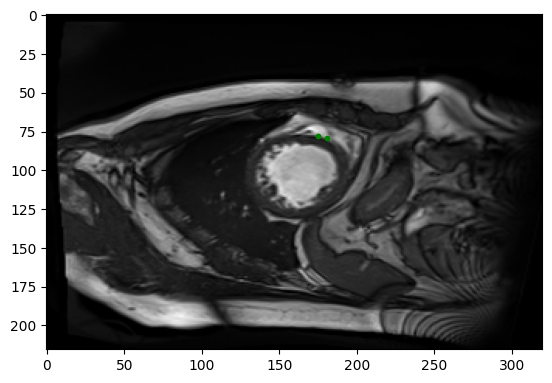

In [62]:
# Plot the chosen input points
plt.imshow(image)
show_points(coords=points , labels=np.array([1]*len(points)), ax=plt.gca())
plt.axis('on')
plt.show()  

In [76]:
labels = set(ground_truth.flatten())# see all classes
labels.remove(0)#remove background label
n_points = 100
masks = []
for i, label in enumerate(labels):
    points = sample_from_class(ground_truth, label, n_points) #sample points from class
    input_labels = np.array([1]*n_points)#label all points as forground
    mask, score, logit = predictor.predict(
                                                                                    point_coords=points,
                                                                                    point_labels=input_labels,
                                                                                    multimask_output=False
                                                                                )#create mask with highest internal score
    masks.append(mask)



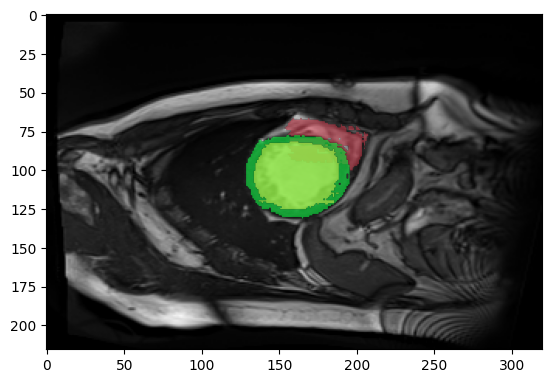

In [77]:
plt.imshow(image)
for mask in masks:
    show_mask(mask, plt.gca(), random_color=True)
plt.axis('on')
plt.show()

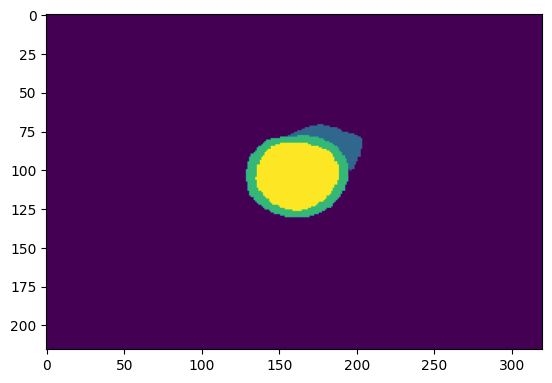

In [70]:
plt.imshow(ground_truth)
plt.show()

## Next steps:
+ find a way to compare masks to ground truth
+ generate many masks for different prompts
+ evaluate the fluctuations of masks depending on the prompt